In [2]:
import os
import pandas as pd
import json
import folium
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  



In [3]:
with open('unemployment_with_youth.csv', 'r',encoding='utf-16') as f:
    read_data = list(f.read().replace('""""','"" ""'))
#
in_quote=False
changed=0
for i in range(len(read_data)):
    if read_data[i] =='"' and read_data[i+1]=='"' and read_data[i-1]!='"':
        in_quote= not in_quote
    if read_data[i]==',' and (not in_quote):
        read_data[i]='#'
        changed+=1
        
matrix=list(map(lambda x: x.split("#"),''.join(read_data).replace('"','').split('\n')))
PDdata=pd.DataFrame(matrix[2:-1])
PDdata.columns=matrix[:2]
PDdata.drop("Total",axis=1,inplace=True)
PDdata.columns=["Canton","Nationalité","stuff","Unemployment rate","Youth unemployment rate","Number of unemployed","Number of youth unemployed","Number of jobseekers","Non-unemployed jobseekers"]
PDdata.drop("stuff",inplace=True,axis=1)
PDdata.replace({"...": np.nan},inplace=True)

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.


In [4]:
PDdata = PDdata.drop(52)
PDdata["Unemployment rate"]=pd.to_numeric(PDdata["Unemployment rate"])
PDdata["Youth unemployment rate"]=pd.to_numeric(PDdata["Youth unemployment rate"])

PDdata["Number of unemployed"]=pd.to_numeric(PDdata["Number of unemployed"].apply(lambda x: x.replace("'","")))
PDdata["Number of jobseekers"]=pd.to_numeric(PDdata["Number of jobseekers"].apply(lambda x: x.replace("'","")))
PDdata["Non-unemployed jobseekers"]=pd.to_numeric(PDdata["Non-unemployed jobseekers"].apply(lambda x: x.replace("'","")))
PDdata["Number of youth unemployed"]=pd.to_numeric(PDdata["Number of youth unemployed"].apply(lambda x: x.replace("'","")))

PDdata["Number of active people"]=PDdata["Number of unemployed"]/(PDdata["Unemployment rate"]/100)
PDdata["Number of active youth"]=PDdata["Number of youth unemployed"]/(PDdata["Youth unemployment rate"]/100)
#Dropping the "Total" entry, which is index 52.


In [5]:
PDdata.head()

,Canton,Nationalité,Unemployment rate,Youth unemployment rate,Number of unemployed,Number of youth unemployed,Number of jobseekers,Non-unemployed jobseekers,Number of active people,Number of active youth
0,Zurich,Etrangers,5.3,5.8,12111,1015,15384,3273,228509.433962,17500.000000
1,Zurich,Suisses,2.5,3.2,15114,2405,18772,3658,604560.000000,75156.250000
2,Berne,Etrangers,5.5,7.7,4900,597,6859,1959,89090.909091,7753.246753
3,Berne,Suisses,1.8,2.2,8758,1406,11526,2768,486555.555556,63909.090909
4,Lucerne,Etrangers,3.9,4.7,1593,217,2902,1309,40846.153846,4617.021277


In [6]:
PDdata["Number of active people"].sum()

4511935.186398289

In [7]:
# PDdata = pd.read_pickle('Rate_Nationality_Canton.pkl')

In [8]:
ch_topo_path = r'ch-cantons.topojson.json'
topo_json_data = json.load(open(ch_topo_path))

In [9]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
folium.TopoJson(topo_json_data,"objects.cantons").add_to(m_ch)
m_ch

We notice that the names of the cantons in the data derived from amstat is not the same as their names in topojason data. For tackling this issue we make a data frame of canton names and we mereg this data frame with the data fram of Suisse people unemployment rate per canton and strangers Unemployment rate per canton.

In [10]:
Suisse = PDdata[PDdata['Nationalité']=='Suisses'][['Canton','Unemployment rate']]

In [11]:
Strangers = PDdata[PDdata['Nationalité']=='Etrangers'][['Canton','Unemployment rate']]

In [12]:
names=pd.DataFrame(list(map(lambda x: x['properties']['name'],topo_json_data["objects"]["cantons"]['geometries'])))
names.columns=["map_name"]
Suisse['map_name'] = list(names['map_name'])
Strangers['map_name'] = list(names['map_name'])
Suisse.head()

,Canton,Unemployment rate,map_name
1,Zurich,2.5,ZÃ¼rich
3,Berne,1.8,Bern/Berne
5,Lucerne,1.3,Luzern
7,Uri,0.4,Uri
9,Schwyz,1.2,Schwyz


We make two choropleths of Suisse people and strangers unemployment rate. For the two maps to be comparable we use the same color scale for two choropleths. Doing so we see that the difference of rates for Suisse people is not so distinguishable this is because that the rate for strangers is generally higher than for Suisse people. We can see this difference clearly by comparing the two choropleth maps.

In [13]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
m_ch.choropleth(geo_data=topo_json_data, topojson="objects.cantons",
                data = Suisse,
                columns=['map_name', 'Unemployment rate'], 
                key_on="feature.properties.name",
                fill_color='BuPu', fill_opacity=0.6,
                line_color='black', highlight=True,
                threshold_scale=[0, 1.8, 3.6, 5.4, 7.2, 9],
                legend_name='Percentage Unemployment for Suisse people  (%)')
m_ch

In [14]:
m_ch = folium.Map([46.8,8], tiles='cartodbpositron', zoom_start=8)
m_ch.choropleth(geo_data=topo_json_data, topojson="objects.cantons",
                data = Strangers,
                columns=['map_name', 'Unemployment rate'], 
                key_on="feature.properties.name",
                fill_color='BuPu', fill_opacity=0.6,
                line_color='black', highlight=True,
                threshold_scale=[0, 1.8, 3.6, 5.4, 7.2, 9],
                legend_name='Percentage Unemployment for Strangers  (%)')
m_ch

In [15]:
PDdata['non youth unemployment rate'] = (PDdata['Number of unemployed']-PDdata['Number of youth unemployed'])*100/(PDdata['Number of active people']-PDdata['Number of active youth'])

In [16]:
PDdata_canton_ind = PDdata.set_index('Canton')

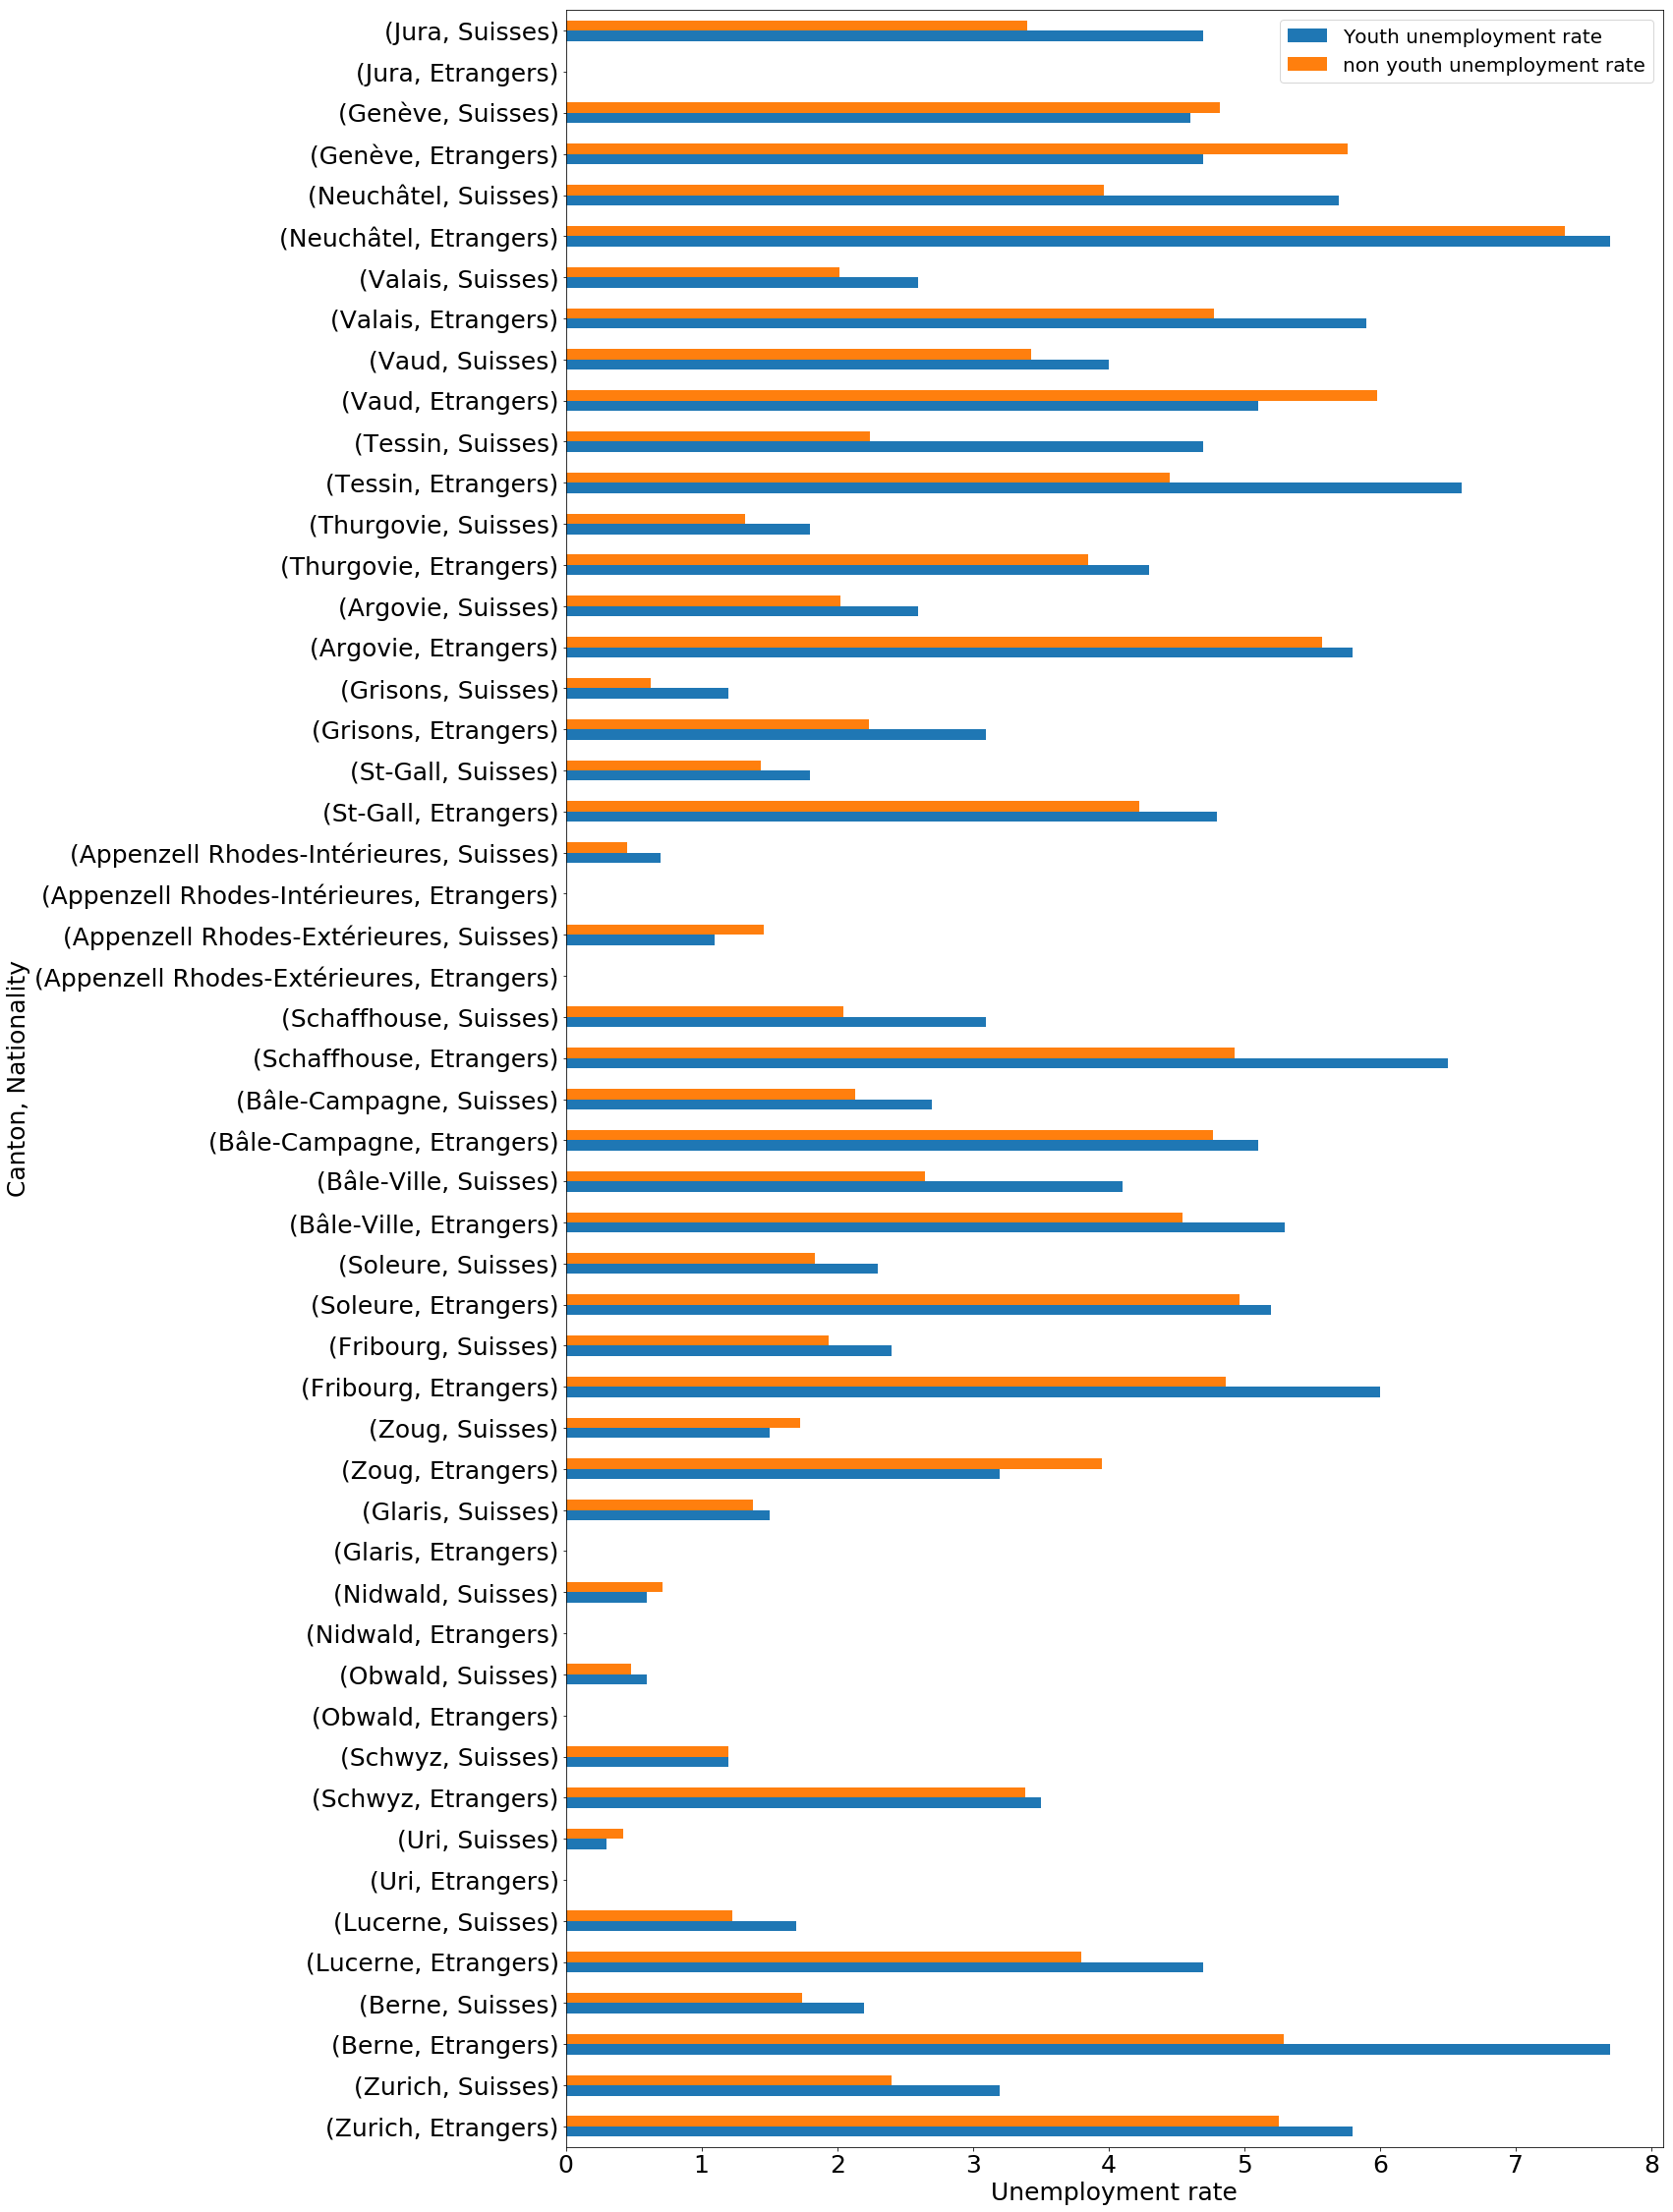

In [28]:
plt.figure(figsize=(20,10))
#sns.barplot(x="Canton", y=["Youth unemployment rate", "non youth unemployment rate"], hue="Nationalité", data=PDdata)
PDdata.plot(x=["Canton", "Nationalité"] , y=["Youth unemployment rate", "non youth unemployment rate"], kind='barh',figsize=(20,40))
plt.xticks(rotation = 0, fontsize = 25)
plt.yticks(fontsize = 25)
plt.legend(fontsize=20)
plt.xlabel('Unemployment rate', fontsize = 25)
plt.ylabel('Canton, Nationality', fontsize = 25);